Bin 0 ≈ low (0–33%)

Bin 1 ≈ medium (33–66%)

Bin 2 ≈ high (66–100%)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

def fairness_analysis(df, target, control_vars, predictors):
    df_clean = df.dropna(subset=control_vars + [target])

    # Stratify using KBinsDiscretizer (quantile binning)
    binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
    binned_controls = binning.fit_transform(df_clean[control_vars])
    
    # Extract bin edges
    bin_edges_dict = {
        var: binning.bin_edges_[i]
        for i, var in enumerate(control_vars)
    }

    # Compute stratum label
    strata_labels = pd.Series(np.sum(binned_controls * (10 ** np.arange(binned_controls.shape[1])), axis=1), name="Stratum")
    df_clean['Stratum'] = strata_labels

    results = []

    for stratum, group in df_clean.groupby('Stratum'):
        if group[target].nunique() < 2 or len(group) < 30:
            continue  # Skip strata with low diversity or small size

        X = group.drop(columns=[target, 'Stratum'])
        y = group[target]

        # Drop protected attributes
        X = X.drop(columns=predictors, errors='ignore')

        model = LGBMClassifier(verbosity=-1, random_state=42)
        scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

        results.append({
            'Stratum': int(stratum),
            'Samples': len(group),
            'Mean Accuracy': np.mean(scores),
            'Std Error': np.std(scores, ddof=1) / np.sqrt(len(scores)),
            'Std Dev': np.std(scores),
        })

    # Create DataFrame of results
    results_df = pd.DataFrame(results)

    # === Plot the results ===
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Stratum'].astype(str), results_df['Mean Accuracy'], 
            yerr=results_df['Std Error'], capsize=5)
    plt.xlabel("Stratum (Grouped by Similar Financial Profiles)")
    plt.ylabel(f"Classification Accuracy (Predicting {target})")
    plt.title(f"Fairness Check: Predictability of {target} After Controlling for Financial Variables")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # === Print bin ranges for interpretability ===
    print("\n=== Bin Ranges for Each Control Variable ===")
    for var, edges in bin_edges_dict.items():
        print(f"{var}:")
        for i in range(len(edges) - 1):
            print(f"  Bin {i}: [{edges[i]:.2f}, {edges[i+1]:.2f})")


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


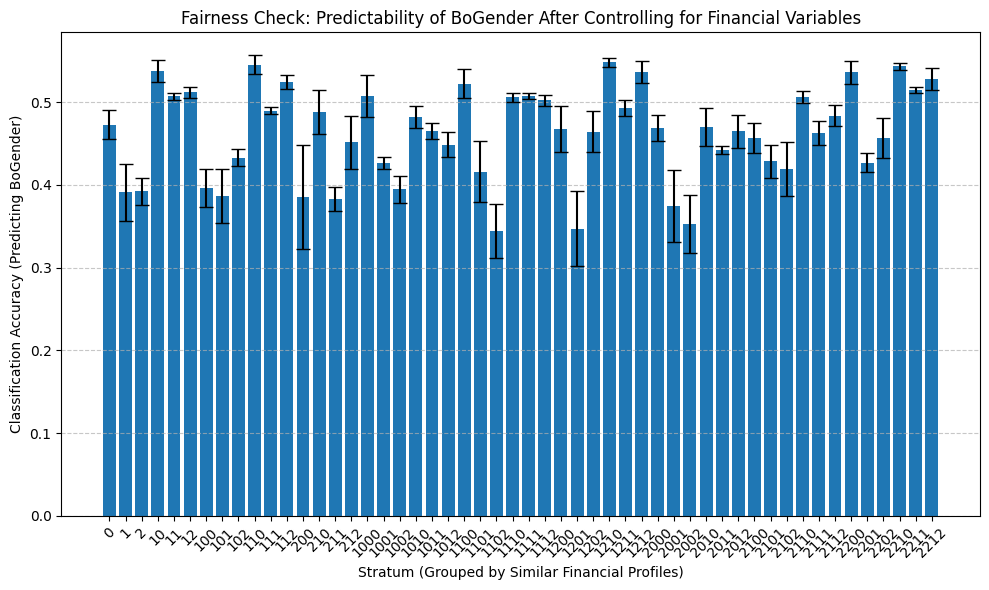


=== Bin Ranges for Each Control Variable ===
Income_adjusted:
  Bin 0: [13897.21, 90124.99)
  Bin 1: [90124.99, 149950.93)
  Bin 2: [149950.93, 14710016.61)
Borrower Credit Score:
  Bin 0: [1.00, 4.00)
  Bin 1: [4.00, 5.00)
Front:
  Bin 0: [0.00, 0.16)
  Bin 1: [0.16, 0.22)
  Bin 2: [0.22, 9.99)
Back:
  Bin 0: [0.00, 0.26)
  Bin 1: [0.26, 0.35)
  Bin 2: [0.35, 1.76)


In [3]:
target = 'BoGender'
control_vars = ['Income_adjusted', 'Borrower Credit Score', 'Front', 'Back']
predictors = ['BoRace', 'CoGender', 'CoRace']
df = pd.read_csv('Samples/BoGender.csv')

fairness_analysis(df, target, control_vars, predictors)

c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


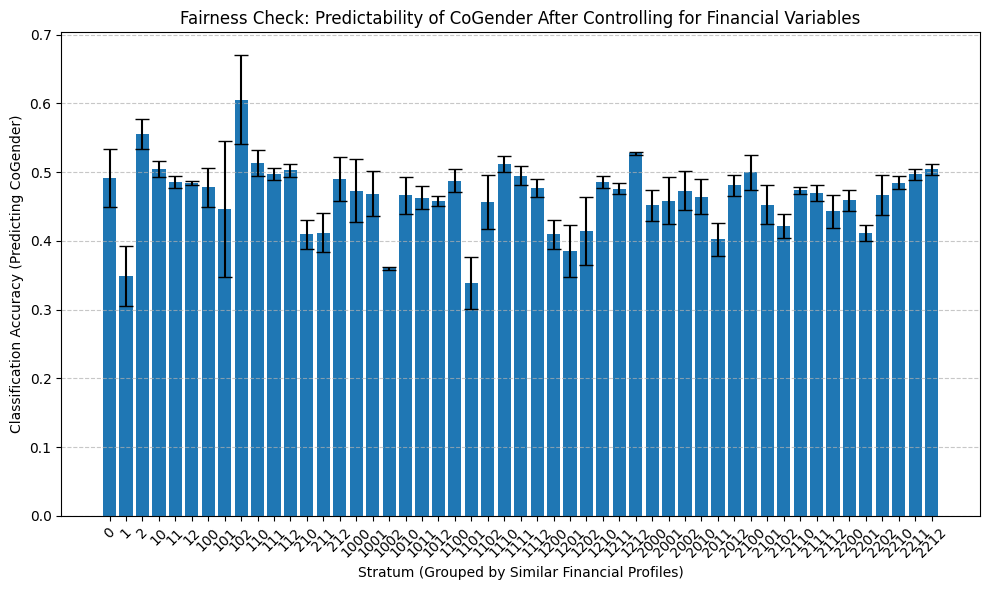


=== Bin Ranges for Each Control Variable ===
Income_adjusted:
  Bin 0: [14235.24, 116864.39)
  Bin 1: [116864.39, 176262.29)
  Bin 2: [176262.29, 14710016.61)
Borrower Credit Score:
  Bin 0: [1.00, 4.00)
  Bin 1: [4.00, 5.00)
Front:
  Bin 0: [0.00, 0.14)
  Bin 1: [0.14, 0.20)
  Bin 2: [0.20, 0.60)
Back:
  Bin 0: [0.00, 0.24)
  Bin 1: [0.24, 0.34)
  Bin 2: [0.34, 0.98)


In [4]:
target = 'CoGender'
control_vars = ['Income_adjusted', 'Borrower Credit Score', 'Front', 'Back']
predictors = ['BoRace', 'BoGender', 'CoRace']
df = pd.read_csv('Samples/CoGender.csv')

fairness_analysis(df, target, control_vars, predictors)

c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class 

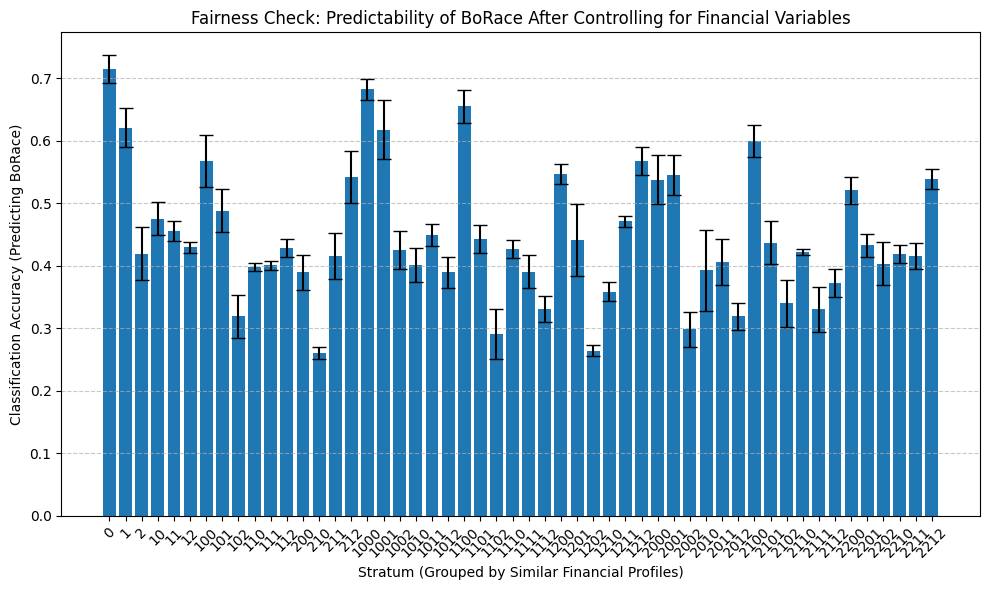


=== Bin Ranges for Each Control Variable ===
Income_adjusted:
  Bin 0: [14141.88, 91745.24)
  Bin 1: [91745.24, 151074.99)
  Bin 2: [151074.99, 3500235.67)
Borrower Credit Score:
  Bin 0: [1.00, 4.00)
  Bin 1: [4.00, 5.00)
Front:
  Bin 0: [0.00, 0.16)
  Bin 1: [0.16, 0.24)
  Bin 2: [0.24, 0.98)
Back:
  Bin 0: [0.01, 0.27)
  Bin 1: [0.27, 0.36)
  Bin 2: [0.36, 0.99)


In [5]:
target = 'BoRace'
control_vars = ['Income_adjusted', 'Borrower Credit Score', 'Front', 'Back']
predictors = ['CoRace', 'CoGender', 'BoGender']
df = pd.read_csv('Samples/BoRace.csv')

fairness_analysis(df, target, control_vars, predictors)

c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class 

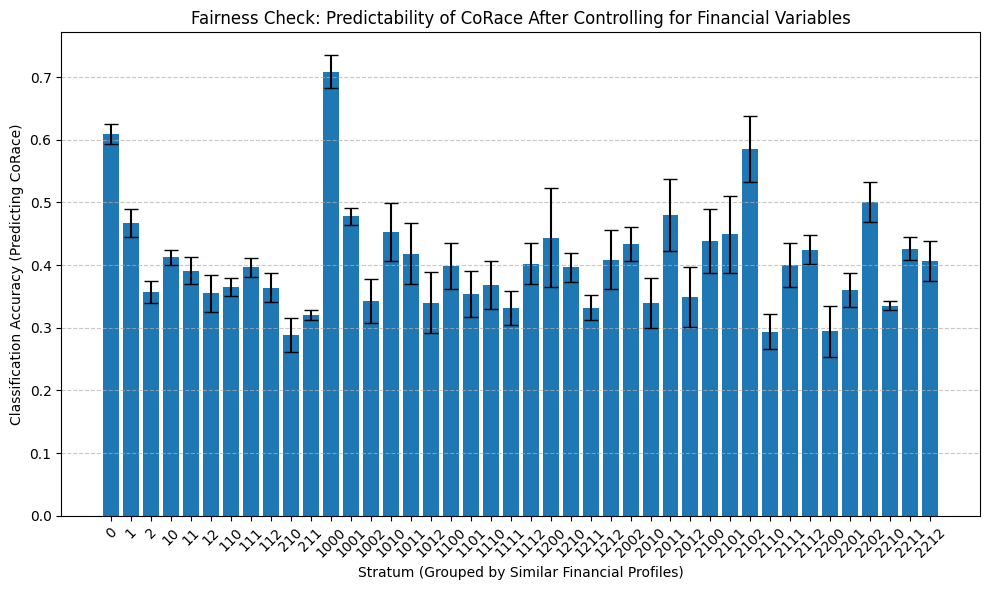


=== Bin Ranges for Each Control Variable ===
Income_adjusted:
  Bin 0: [21659.59, 114379.97)
  Bin 1: [114379.97, 176169.20)
  Bin 2: [176169.20, 3747673.30)
Borrower Credit Score:
  Bin 0: [1.00, 4.00)
  Bin 1: [4.00, 5.00)
Front:
  Bin 0: [0.00, 0.15)
  Bin 1: [0.15, 0.21)
  Bin 2: [0.21, 0.64)
Back:
  Bin 0: [0.00, 0.26)
  Bin 1: [0.26, 0.36)
  Bin 2: [0.36, 1.03)


In [6]:
target = 'CoRace'
control_vars = ['Income_adjusted', 'Borrower Credit Score', 'Front', 'Back']
predictors = ['BoRace', 'CoGender', 'BoGender']
df = pd.read_csv('Samples/CoRace.csv')

fairness_analysis(df, target, control_vars, predictors)

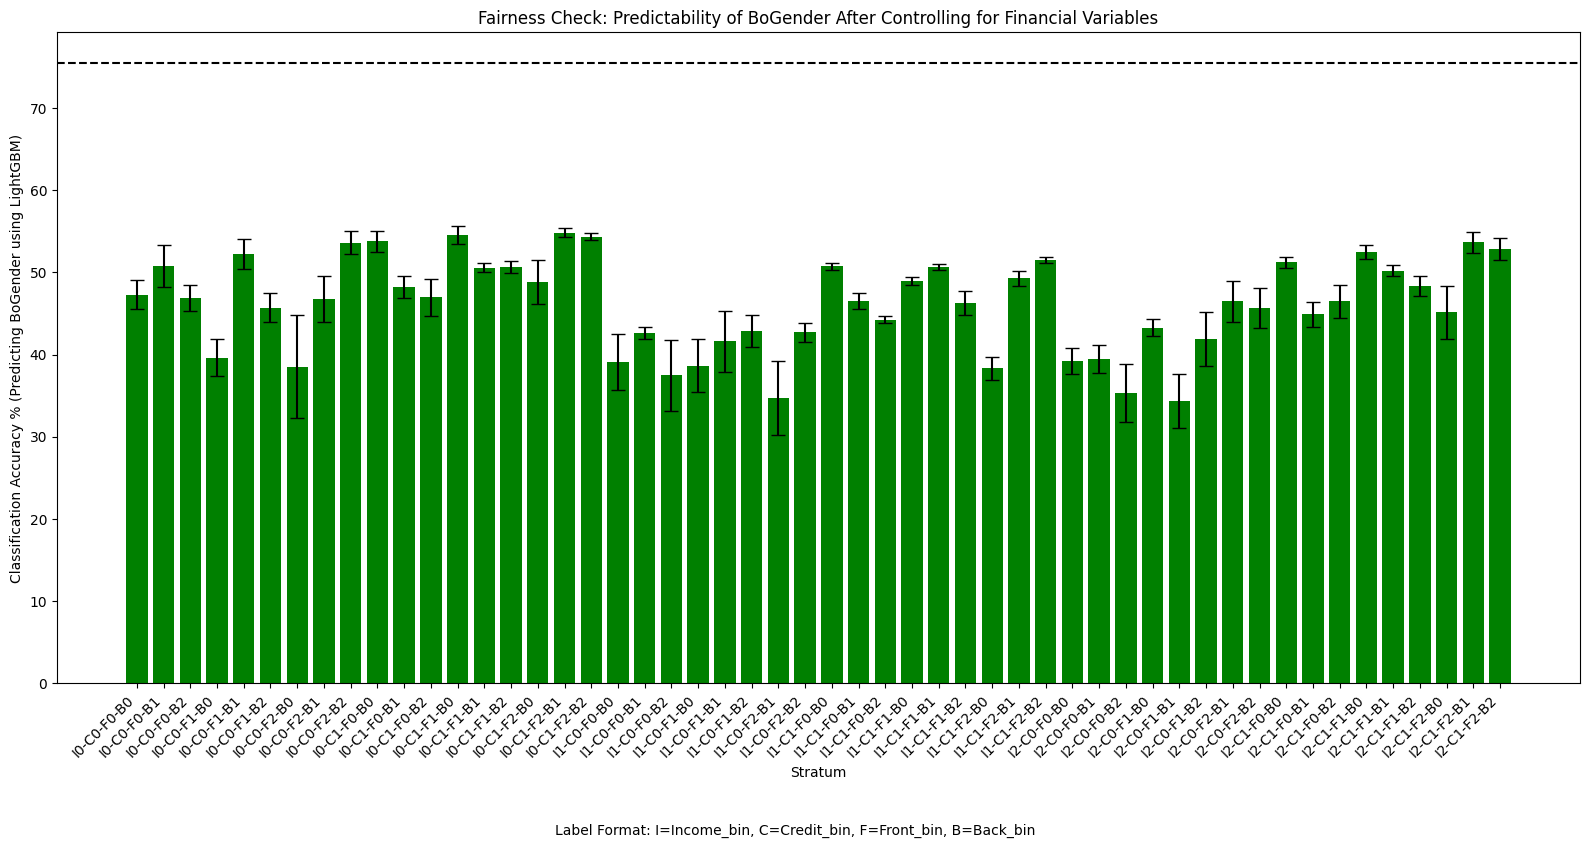

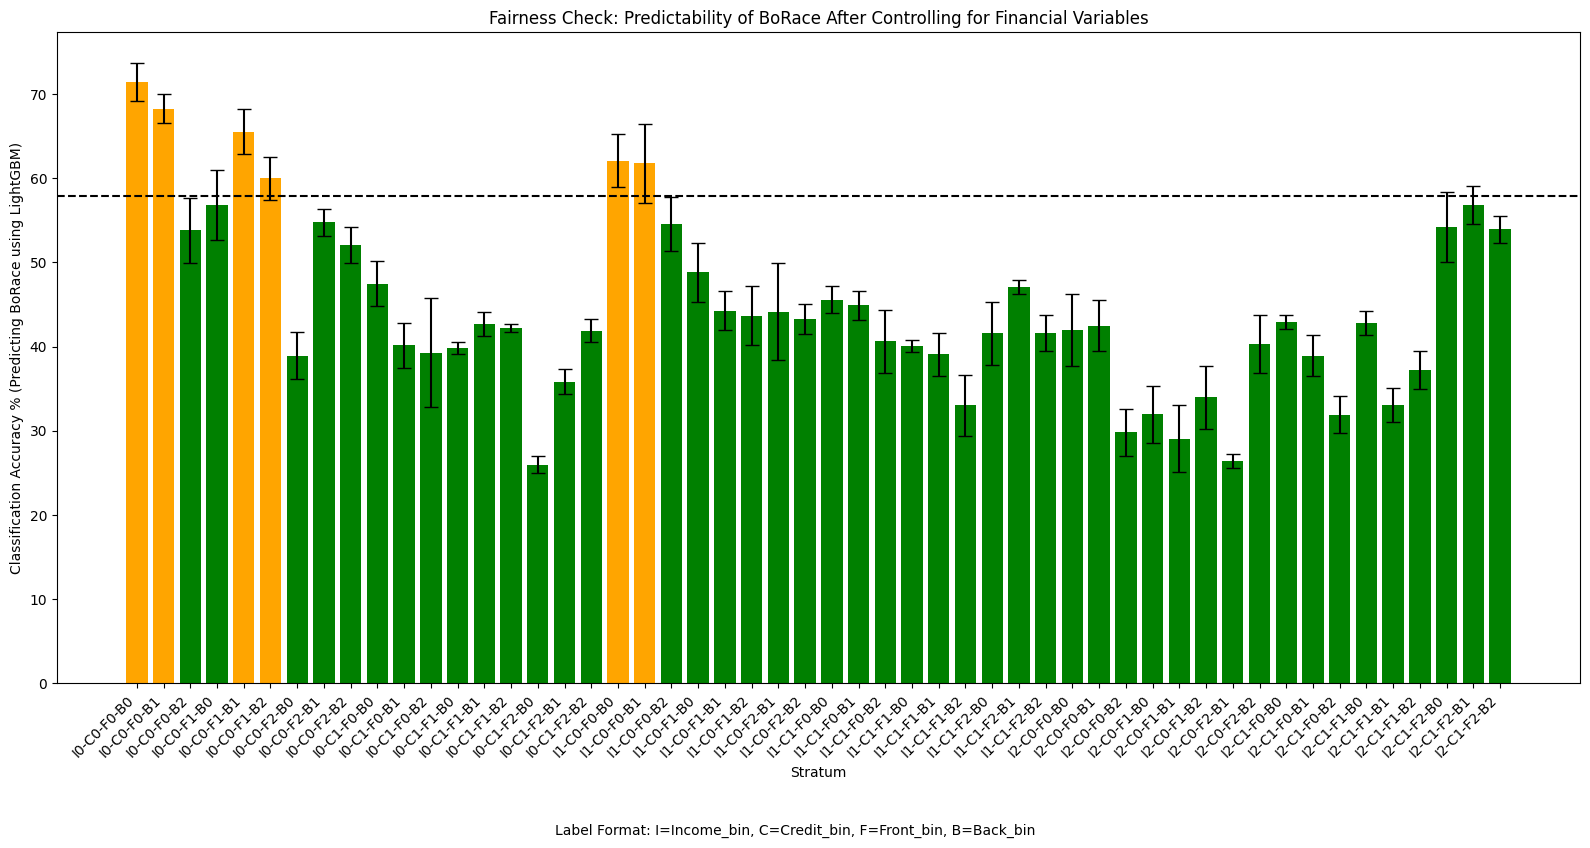

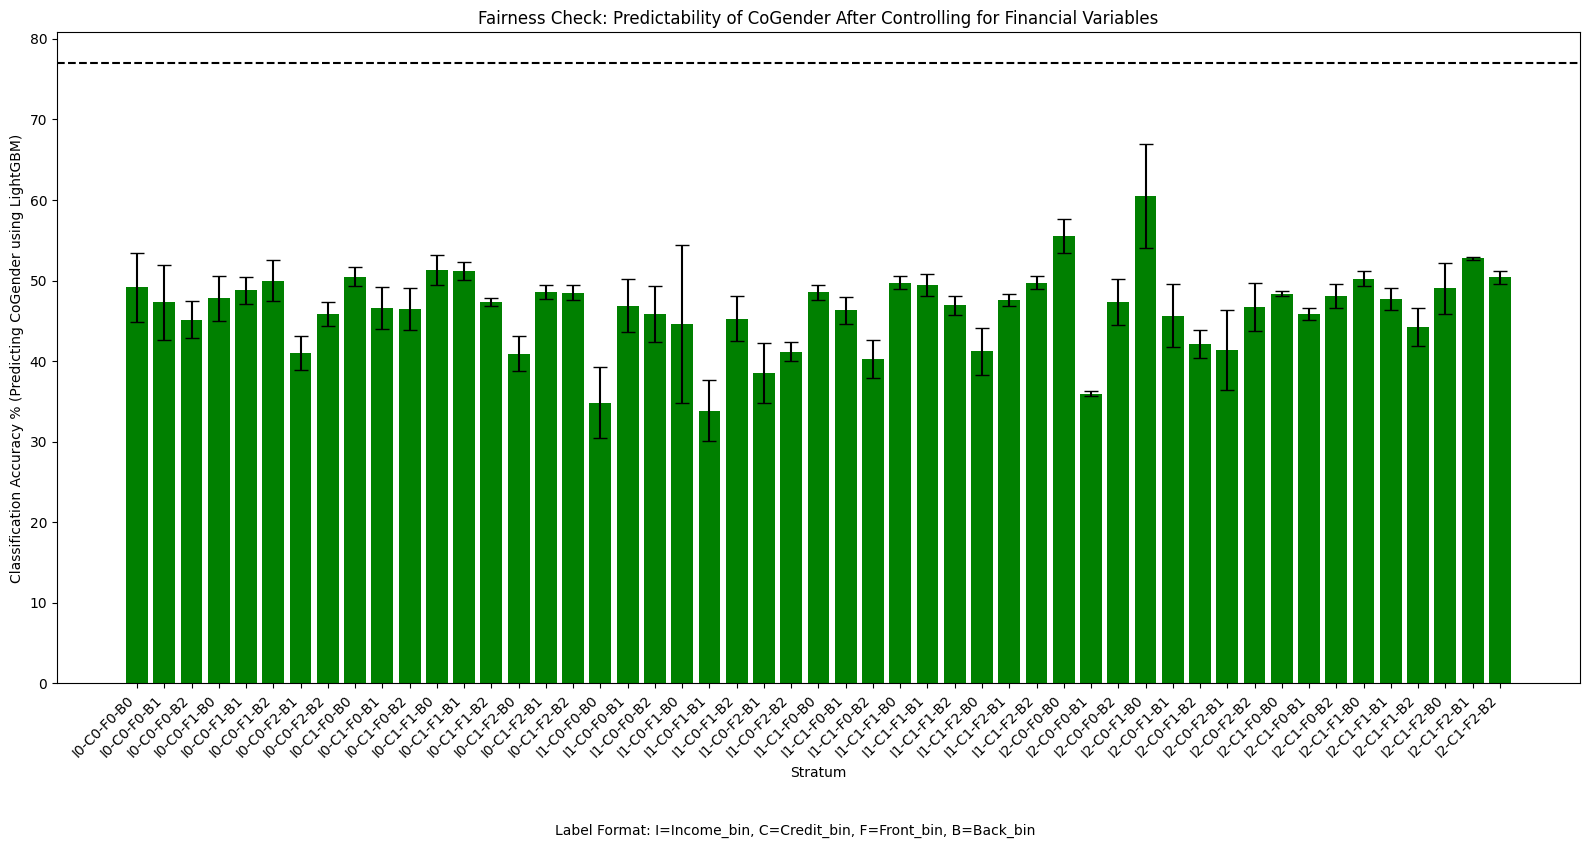

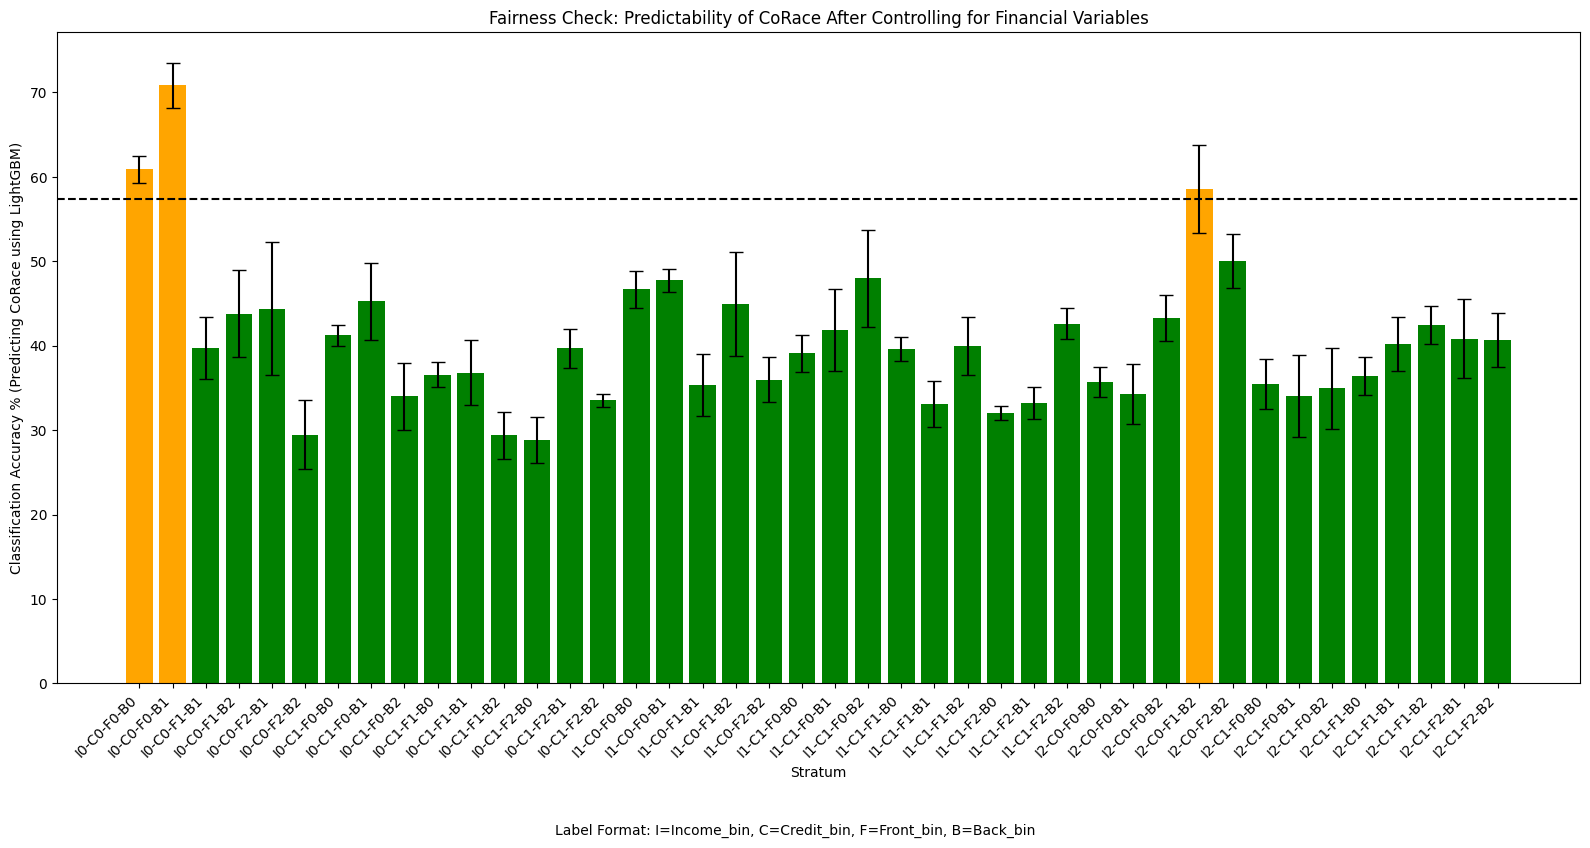

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

fairness_results = [
    "BoGender_Fairness.csv",
    "BoRace_Fairness.csv",
    "CoGender_Fairness.csv",
    "CoRace_Fairness.csv"
]

for file in fairness_results:
    target = file.split("_")[0]
    results_df = pd.read_csv(file)
    model_score = pd.read_csv(f'{target}_CV/results_cv_10_folds.csv')
    accuracy = model_score.loc[model_score['Unnamed: 0'] == 'LightGBM' , 'Accuracy'].values[0]*100

    results_df["Stratum_Label"] = (
    "I" + results_df["Income_adjusted_bin"].astype(int).astype(str) + "-" +
    "C" + results_df["Borrower Credit Score_bin"].astype(int).astype(str) + "-" +
    "F" + results_df["Front_bin"].astype(int).astype(str) + "-" +
    "B" + results_df["Back_bin"].astype(int).astype(str)
    )

    results_df = results_df.sort_values(
        by=["Income_adjusted_bin", "Borrower Credit Score_bin", "Front_bin", "Back_bin"]
    ).reset_index(drop=True)

    colors = ["orange" if acc > accuracy else "green" for acc in results_df["Mean Accuracy"]*100]
    plt.figure(figsize=(16, 8))
    plt.bar(results_df["Stratum_Label"], results_df["Mean Accuracy"]*100, 
            yerr=results_df["Std Error"]*100, capsize=5, color=colors)
    plt.axhline(y=accuracy, color='black', linestyle='--', linewidth=1.5, label=f"Threshold = {accuracy}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f"Classification Accuracy % (Predicting {target} using LightGBM)")
    plt.xlabel("Stratum")
    plt.title(f"Fairness Check: Predictability of {target} After Controlling for Financial Variables")
    legend_text = "Label Format: I=Income_bin, C=Credit_bin, F=Front_bin, B=Back_bin"
    plt.figtext(0.5, -0.05, legend_text, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    save_path = f"{target}_Fairness_Plot.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()